In [1]:
%load_ext jupyter_black

In [2]:
import pandas as pd

ENTRY_FEE = 375
MAX_WINS = 7
MAX_LOSSES = 3

In [3]:
def bo1_pdf(
    w: int, l: int, p: float, max_wins: int = MAX_WINS, max_losses: int = MAX_LOSSES
) -> float:
    # Wins and losses must be positive.
    if w < 0 or l < 0:
        return 0.0

    # Losses and wins cannot be bigger than the max: out of bounds.
    if l > max_losses or w > max_wins:
        return 0.0

    # Either win or lose the event, not both.
    if l == max_losses and w == max_wins:
        return 0.0

    # Initial state.
    if w == 0 and l == 0:
        return 1.0
    else:
        if w == 0 and l > 0:
            return (1 - p) * bo1_pdf(w, l - 1, p)
        elif w > 0 and l == 0:
            return p * bo1_pdf(w - 1, l, p)
        elif w == max_wins:
            return p * bo1_pdf(w - 1, l, p)
        elif l == max_losses:
            return (1 - p) * bo1_pdf(w, l - 1, p)
        else:
            return p * bo1_pdf(w - 1, l, p) + (1 - p) * bo1_pdf(w, l - 1, p)

In [4]:
df_rewards = pd.read_csv("bo1_rewards.csv").rename(
    columns={
        "Wins": "wins",
        "Gems": "gems",
        "Packs": "packs",
        "Play-In Point": "play_in_point",
        "Equivalent Gems": "eq_gems",
        "ROI": "roi",
    }
)
df_rewards

,wins,gems,packs,play_in_point,eq_gems,roi
0,0,25,0,0,25,0.07
1,1,50,0,0,50,0.13
2,2,75,1,0,275,0.73
3,3,200,1,0,400,1.07
4,4,300,1,0,500,1.33
5,5,400,2,0,800,2.13
6,6,450,2,0,850,2.27
7,7,500,3,1,1100,2.93


In [5]:
list_pdf = []


def get_event_pdf(
    p: float, max_wins: int = MAX_WINS, max_losses: int = MAX_LOSSES
) -> pd.DataFrame:
    list_pdf = []
    for w in range(0, max_wins + 1):
        for l in range(0, max_losses + 1):
            list_pdf.append(
                {"wins": w, "losses": l, "pdf": bo1_pdf(w, l, p, max_wins, max_losses)}
            )

    df_pdf = (
        pd.DataFrame(list_pdf)
        .query(f"losses=={max_losses} or wins=={max_wins}")
        .query("pdf>0")
        .assign(games=lambda df: df.wins + df.losses)
    )
    return df_pdf

In [6]:
df_pdf_event = get_event_pdf(0.5)
df_pdf_event.round(2)

,wins,losses,pdf,games
3,0,3,0.12,3
7,1,3,0.19,4
11,2,3,0.19,5
15,3,3,0.16,6
19,4,3,0.12,7
23,5,3,0.08,8
27,6,3,0.05,9
28,7,0,0.01,7
29,7,1,0.03,8
30,7,2,0.05,9


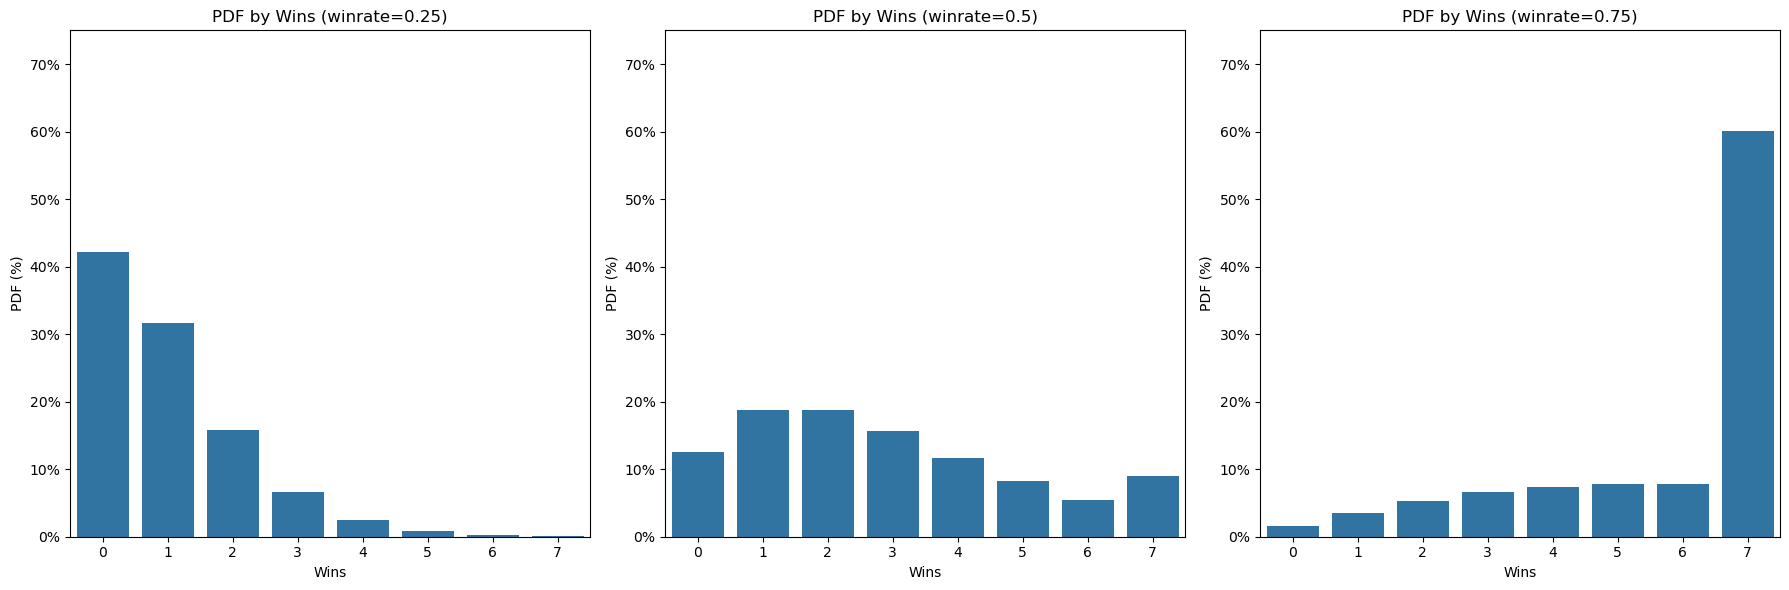

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(18, 6))

for i, p in enumerate([0.25, 0.5, 0.75], start=1):
    plt.subplot(1, 3, i)
    df_pdf = (
        get_event_pdf(p, MAX_WINS, MAX_LOSSES)
        .groupby("wins")
        .agg({"pdf": "sum"})
        .reset_index()
    )
    sns.barplot(data=df_pdf, x="wins", y="pdf")
    plt.title(f"PDF by Wins (winrate={p})")
    plt.xlabel("Wins")
    plt.ylabel("PDF (%)")
    plt.ylim(0, 0.75)  # Set the y-axis limits to match across all subplots
    plt.gca().yaxis.set_major_formatter(
        plt.FuncFormatter(lambda y, _: "{:.0%}".format(y))
    )

plt.tight_layout()
plt.show()

In [8]:
get_event_pdf(0.6).merge(df_rewards, how="left", on="wins").assign(
    gems_per_game=lambda df: df.gems / df.games,
    profit=lambda df: df.eq_gems - ENTRY_FEE,
    profit_per_game=lambda df: df.profit / df.games,
    win_rate=0.6,
).groupby("win_rate").apply(
    lambda x: pd.Series(
        {
            "avg_wins": (x["wins"] * x["pdf"]).sum(),
            "avg_games": (x["games"] * x["pdf"]).sum(),
            "avg_gems": (x["gems"] * x["pdf"]).sum(),
            "avg_packs": (x["packs"] * x["pdf"]).sum(),
            "avg_eq_gems": (x["eq_gems"] * x["pdf"]).sum(),
            "avg_profit": (x["profit"] * x["pdf"]).sum(),
            "avg_gems_per_game": (x["gems_per_game"] * x["pdf"]).sum(),
        }
    )
).round(
    2
)

/var/folders/54/5dpgyh313k36rflz4hwnw0y80000gn/T/ipykernel_46380/1014408179.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ).groupby("win_rate").apply(


,avg_wins,avg_games,avg_gems,avg_packs,avg_eq_gems,avg_profit,avg_gems_per_game
win_rate,,,,,,,
0.6,3.95,6.58,278.02,1.47,572.52,197.52,37.26


In [9]:
df_pdf_event.merge(df_rewards, how="left", on="wins").assign(
    gems_per_game=lambda df: df.gems / df.games
).round(2)

,wins,losses,pdf,games,gems,packs,play_in_point,eq_gems,roi,gems_per_game
0,0,3,0.12,3,25,0,0,25,0.07,8.33
1,1,3,0.19,4,50,0,0,50,0.13,12.50
2,2,3,0.19,5,75,1,0,275,0.73,15.00
3,3,3,0.16,6,200,1,0,400,1.07,33.33
4,4,3,0.12,7,300,1,0,500,1.33,42.86
5,5,3,0.08,8,400,2,0,800,2.13,50.00
6,6,3,0.05,9,450,2,0,850,2.27,50.00
7,7,0,0.01,7,500,3,1,1100,2.93,71.43
8,7,1,0.03,8,500,3,1,1100,2.93,62.50
9,7,2,0.05,9,500,3,1,1100,2.93,55.56


In [10]:
import numpy as np

win_rates = np.linspace(0, 1, num=1_000)
df_expected_values = (
    pd.concat([get_event_pdf(p).assign(win_rate=p) for p in win_rates], axis=0)
    .merge(df_rewards, how="left", on="wins")
    .assign(
        eq_profit=lambda df: df.eq_gems - ENTRY_FEE,
        profit=lambda df: df.gems - ENTRY_FEE,
        wins_x_w=lambda df: df.wins * df.pdf,
        games_x_w=lambda df: df.games * df.pdf,
        gems_x_w=lambda df: df.gems * df.pdf,
        eq_gems_x_w=lambda df: df.eq_gems * df.pdf,
        eq_profit_x_w=lambda df: df.eq_profit * df.pdf,
        profit_x_w=lambda df: df.profit * df.pdf,
        packs_x_w=lambda df: df.packs * df.pdf,
    )
    .groupby("win_rate")
    .agg(
        avg_wins=("wins_x_w", "sum"),
        avg_games=("games_x_w", "sum"),
        avg_gems=("gems_x_w", "sum"),
        avg_eq_gems=("eq_gems_x_w", "sum"),
        avg_eq_profit=("eq_profit_x_w", "sum"),
        avg_profit=("profit_x_w", "sum"),
        avg_packs=("packs_x_w", "sum"),
    )
    .reset_index()
)

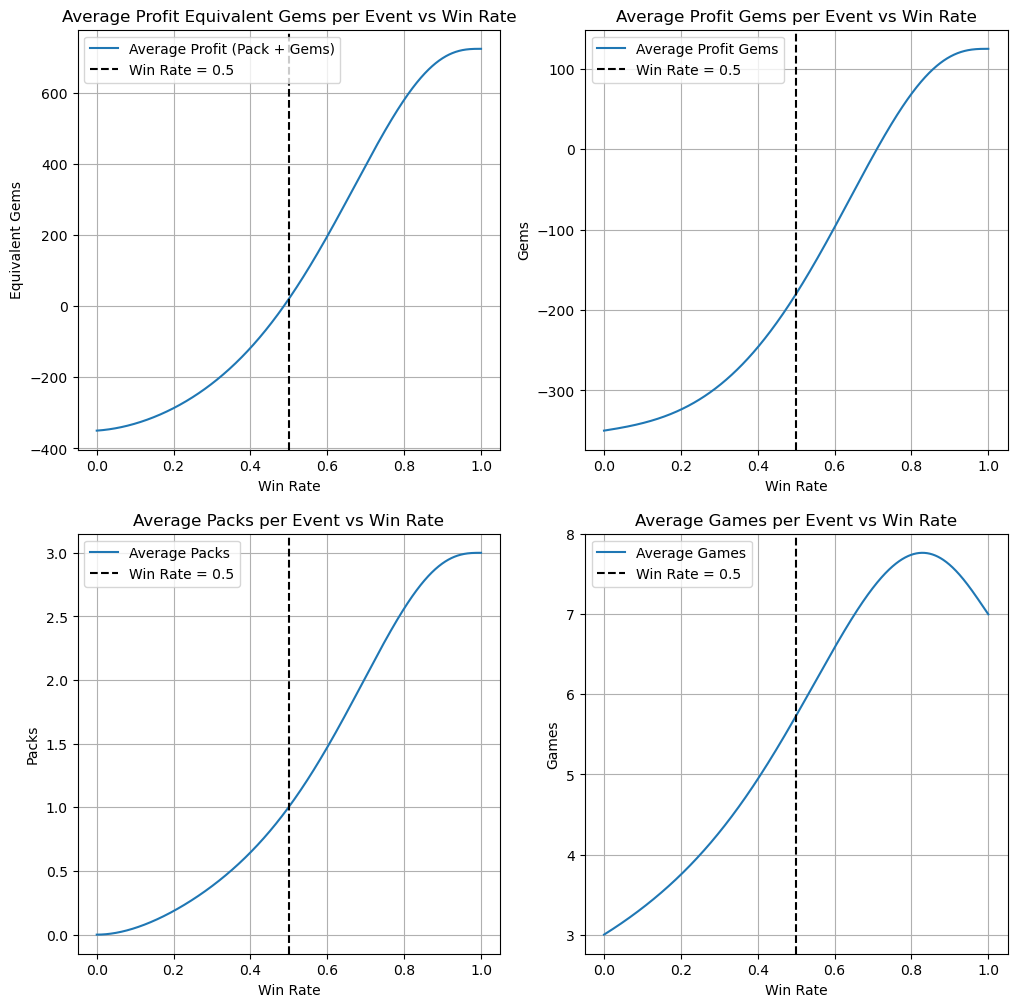

In [11]:
# Plotting avg_gems_per_game vs win_rate
plt.figure(figsize=(12, 12))

# Plotting Average Profit
plt.subplot(2, 2, 1)
sns.lineplot(
    data=df_expected_values,
    x="win_rate",
    y="avg_eq_profit",
    label="Average Profit (Pack + Gems)",
)
plt.axvline(x=0.5, color="k", linestyle="--", label="Win Rate = 0.5")
plt.title("Average Profit Equivalent Gems per Event vs Win Rate")
plt.xlabel("Win Rate")
plt.ylabel("Equivalent Gems")
plt.grid(True)
plt.legend()

# Plotting Average Profit
plt.subplot(2, 2, 2)
sns.lineplot(
    data=df_expected_values,
    x="win_rate",
    y="avg_profit",
    label="Average Profit Gems",
)
plt.axvline(x=0.5, color="k", linestyle="--", label="Win Rate = 0.5")
plt.title("Average Profit Gems per Event vs Win Rate")
plt.xlabel("Win Rate")
plt.ylabel("Gems")
plt.grid(True)
plt.legend()

# Plotting Average Packs
plt.subplot(2, 2, 3)
sns.lineplot(
    data=df_expected_values,
    x="win_rate",
    y="avg_packs",
    label="Average Packs",
)
plt.axvline(x=0.5, color="k", linestyle="--", label="Win Rate = 0.5")
plt.title("Average Packs per Event vs Win Rate")
plt.xlabel("Win Rate")
plt.ylabel("Packs")
plt.grid(True)
plt.legend()

# Plotting Average Games
plt.subplot(2, 2, 4)
sns.lineplot(
    data=df_expected_values, x="win_rate", y="avg_games", label="Average Games"
)
plt.axvline(x=0.5, color="k", linestyle="--", label="Win Rate = 0.5")
plt.title("Average Games per Event vs Win Rate")
plt.xlabel("Win Rate")
plt.ylabel("Games")
plt.grid(True)
plt.legend()